<a href="https://colab.research.google.com/github/LOGANAYAGISASI/Detr_Vehicle_Detection/blob/main/TEST_detr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.0.1+cu118 True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
num_classes = 8
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('/content/drive/MyDrive/Object_detection_DETR/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.7MB/s]


In [4]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [6]:
import matplotlib.pyplot as plt

In [7]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

### Boilerplate functions to display fine-tuned results

In [8]:
import cv2
def plot_finetuned_results(pil_img, output_imagename,prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    #output_image_path="/content/drive/MyDrive/Object_detection_DETR/test_output/"+output_imagename
    #plt.savefig(output_image_path)
    plt.show()

In [14]:
def run_worflow(my_image, my_model,output_filename):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.6]:

    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,output_filename,
                           probas_to_keep,
                           bboxes_scaled)


### With a test image

In [15]:
from PIL import Image
finetuned_classes = ['None','AutoRikshaw', 'Bike', 'Bus', 'Car', 'Maxi Cab', 'Mini Truck', 'Truck']


In [11]:
!unzip /content/drive/MyDrive/Object_detection_DETR/AU-INV-P.v9i.coco.zip -d /content

Archive:  /content/drive/MyDrive/Object_detection_DETR/AU-INV-P.v9i.coco.zip
 extracting: /content/README.dataset.txt  
 extracting: /content/README.roboflow.txt  
   creating: /content/test/
 extracting: /content/test/1102_jpg.rf.c0c42e164d28a3f3bbbb3dfef16f4a2c.jpg  
 extracting: /content/test/12_jpg.rf.ed46cd81a704174b2d7fc7da0a8d09df.jpg  
 extracting: /content/test/1679389202315_jpg.rf.62f8c23aee8f54d65044c0d84677daf4.jpg  
 extracting: /content/test/1679389202324_jpg.rf.e1e5100e86b00a7151b83b0bd7731e9d.jpg  
 extracting: /content/test/1679389316474_jpg.rf.2f8aaa780d8edfa714d1834952c5b34e.jpg  
 extracting: /content/test/1679389428046_jpg.rf.46e502a1e9ca602ae3a04928b229f149.jpg  
 extracting: /content/test/1679389515984_jpg.rf.004a1bf981e2e5786db1f627153c9394.jpg  
 extracting: /content/test/1679389742889_jpg.rf.245298209eb060aef094c1770135818d.jpg  
 extracting: /content/test/1679648595761_jpg.rf.ca009412878bcb86472ff2904c576d96.jpg  
 extracting: /content/test/1680236120844_jpg.

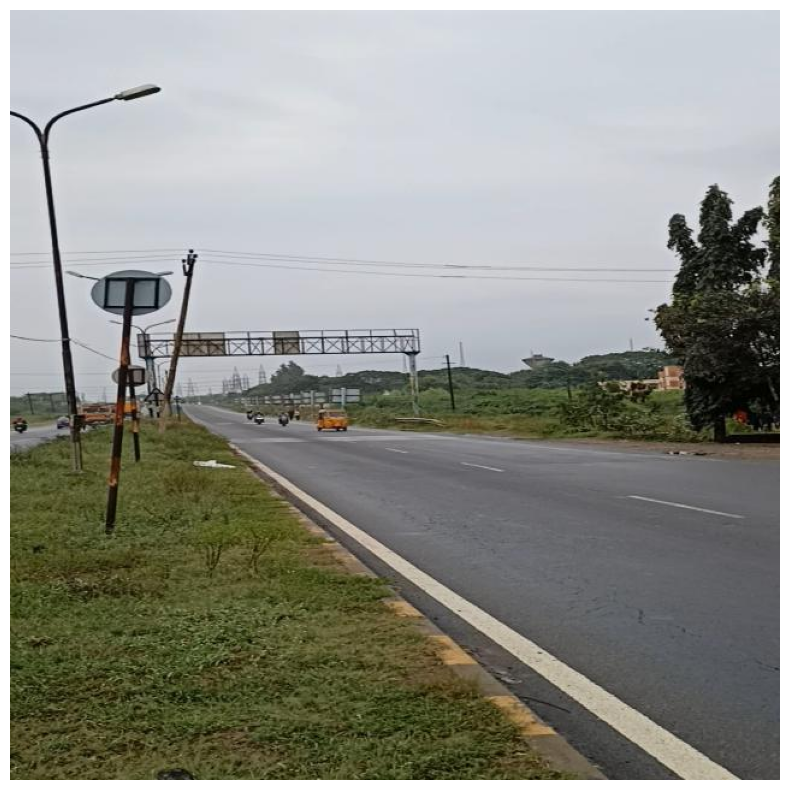

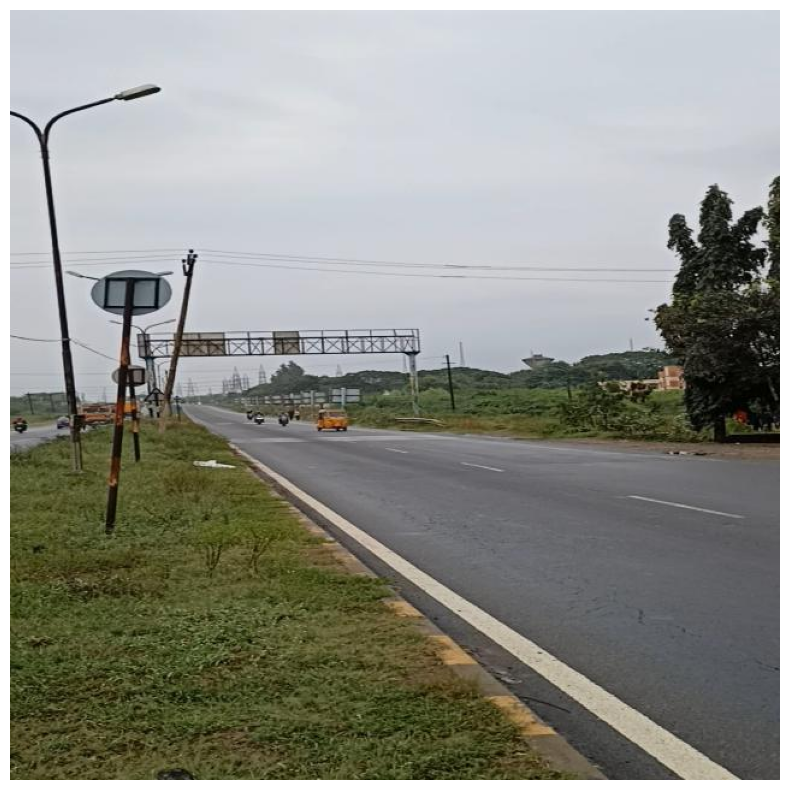

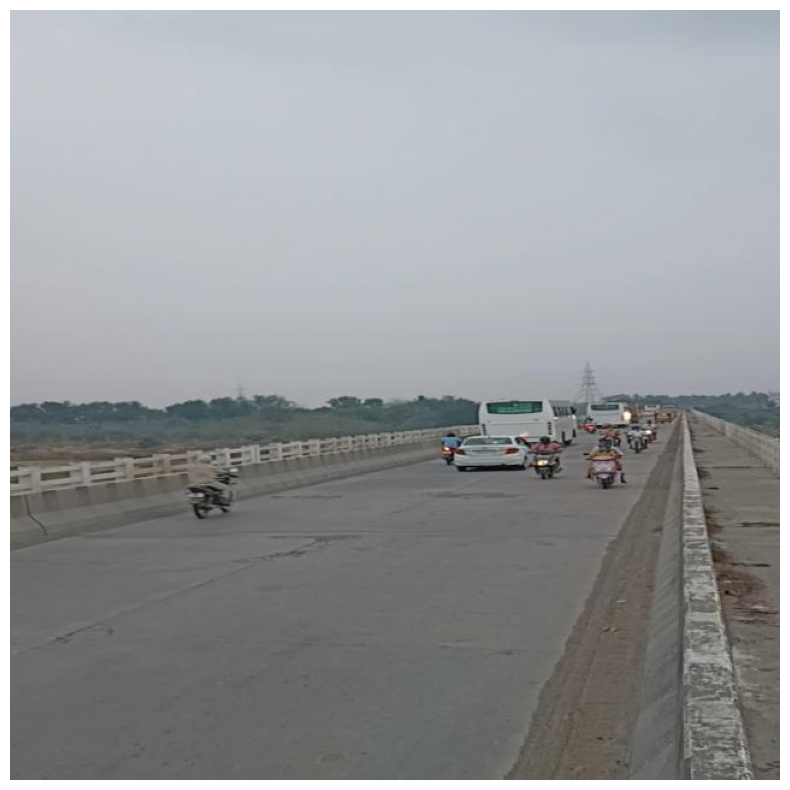

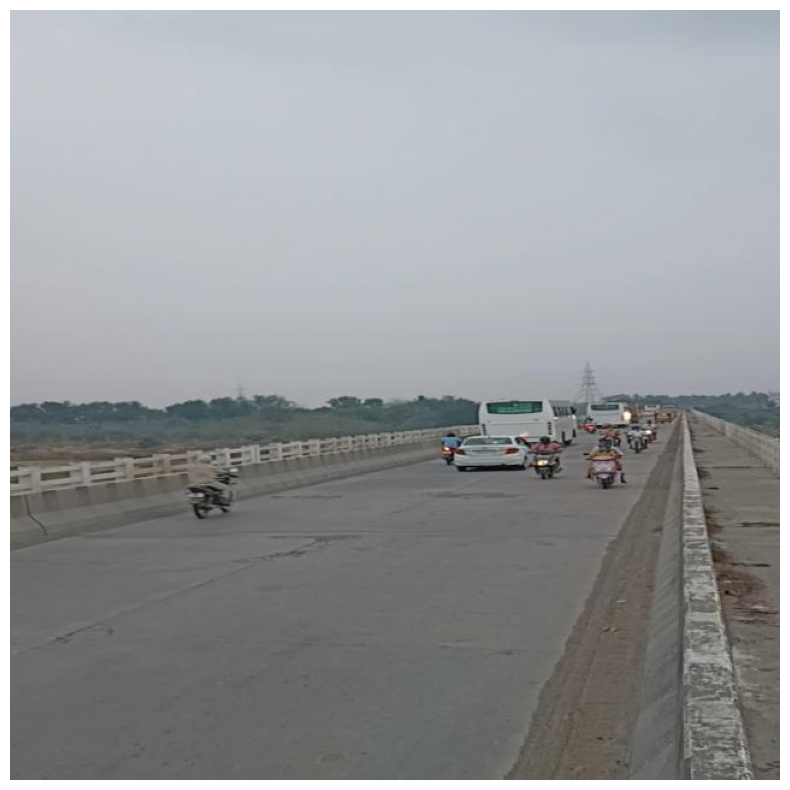

KeyboardInterrupt: ignored

In [12]:
import imutils
import cv2
import time
from imutils import paths
from google.colab.patches import cv2_imshow
imagePaths = list(paths.list_images("/content/test/"))
for imagePath in imagePaths:
  im = Image.open(imagePath)
  file_name = imagePath.split('/')[-1]
  run_worflow(im,model,file_name)
  time.sleep(5)





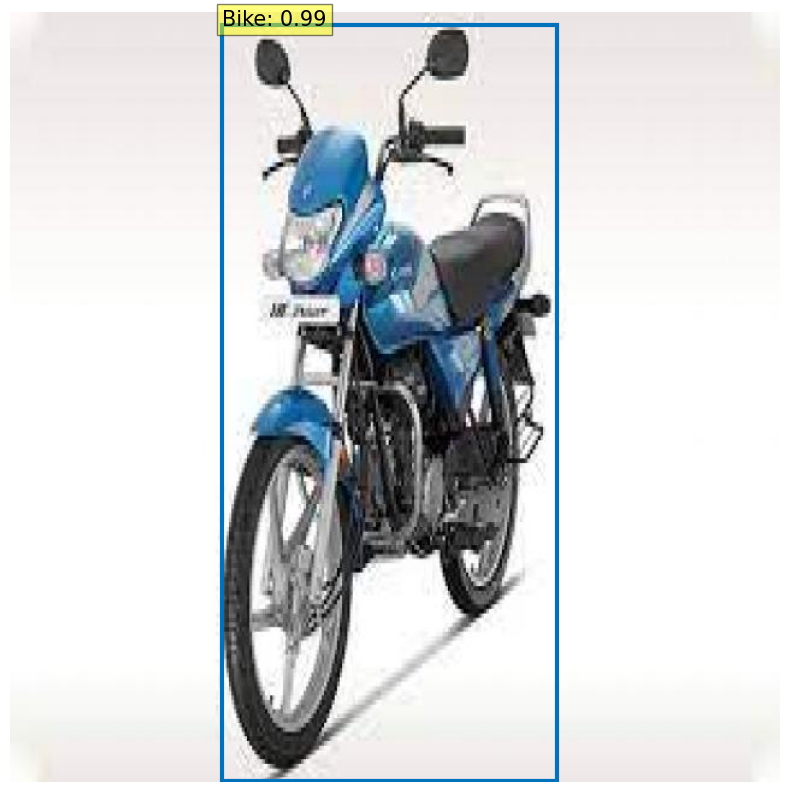

In [16]:
file_name = "/content/test/12_jpg.rf.ed46cd81a704174b2d7fc7da0a8d09df.jpg"
im = Image.open(file_name)
run_worflow(im,model,file_name)